In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import warnings

import gseapy as gp
from gseapy.plot import barplot, dotplot
import gffpandas.gffpandas as gffpd

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

path_to_data='/Users/aleksandradenisova/Desktop/coursework/data/'

In [5]:
order = pd.read_csv(f'{path_to_data}stage4/sorted_inno_sp.csv')
order = order.rename(columns = {'VGL ID':'sp2'})
order.head()

,TotInno_resResEff2022,sp2
0,1.974601,bHirRus1
1,1.950304,bAquChr1
2,1.565219,bCorMon1
3,1.445271,bEriRub2
4,1.357739,bSteHir1


In [6]:
table_names = ['two_alleles.tsv', 'fixed_inno.tsv', 'fixed_noninno.tsv']
cons_in_table = ['cons','inno','non_inno']

all_dfs = []
for i in range(3):
    df = pd.read_csv(f'{path_to_data}final_data/{table_names[i]}', sep = '\t')
    df['start'] = df['start']+1 
    df['type'] = cons_in_table[i]
    
    print(f'number of positions:  {df.shape[0]}')
    
    df3 = df[(((df['n_inno']==4)&(df['n_noninno']==4)) |
              (((df['n_inno']==3)&(df['n_noninno']==4))&((df['inno_N']==1)|(df['inno_-']==1)))|
             (((df['n_noninno']==3)&(df['n_inno']==4))&((df['noninno_N']==1)|(df['noninno_-']==1))))
              &(df[cons_in_table[i]]==True)]

    print(f'number of positions:  {df3.shape[0]}')
    
    all_dfs.append(df3)
    
df = pd.concat(all_dfs)

number of positions:  12271
number of positions:  2160
number of positions:  13637
number of positions:  2479
number of positions:  10663
number of positions:  1983


In [7]:
df

,Unnamed: 0,start,cons,inno,non_inno,Ref_inno,Alt_noninno,n_inno,n_noninno,n,inno_N,inno_-,noninno_N,noninno_-,chrom,type
2,368370,407365,True,False,False,A,G,4,4,8,0,0,0,0,NC_044211.2,cons
19,1136605,1305679,True,False,False,C,T,4,3,7,0,0,0,1,NC_044211.2,cons
20,1293448,1481305,True,False,False,C,T,4,4,8,0,0,0,0,NC_044211.2,cons
23,1614786,1837254,True,False,False,A,G,3,4,7,0,1,0,0,NC_044211.2,cons
27,1750777,1997068,True,False,False,A,G,4,4,8,0,0,0,0,NC_044211.2,cons
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10612,55610609,74758278,False,False,True,"A,C",T,4,3,7,0,0,0,1,NC_044241.2,non_inno
10616,55805926,75069698,False,False,True,"T,G",C,3,4,7,0,1,0,0,NC_044241.2,non_inno
10619,55920884,75249200,False,False,True,"A,C",G,4,4,8,0,0,0,0,NC_044241.2,non_inno
10634,207335,765862,False,False,True,"A,T",G,4,3,7,0,0,0,1,NC_044242.2,non_inno


In [8]:
df_chrom = pd.read_csv('~/Desktop/coursework/data/stage2/chroms_zebra.tsv', sep = '\t')[:-1]

df_chrom['Molecule name'] = df_chrom['Molecule name'].apply(lambda x: x.split()[1])
df1 = df_chrom[['RefSeq sequence', 'Molecule name']].rename(columns= {'RefSeq sequence':'chrom'})
df1.head()

,chrom,Molecule name
0,NC_044211.2,1
1,NC_044212.2,1A
2,NC_044213.2,2
3,NC_044214.2,3
4,NC_044215.2,4


In [10]:
df_p = df
    
df2 = pd.merge(df1,df_p, on='chrom').rename(columns = {
                                                    'chrom':'#CHROM', 'start':'POS', 
                                                    'Alt_noninno':'REF', 'Ref_inno':'ALT'})
df2['ID'] = '.'
df2['FILTER'] = '.'
df2['INFO'] = '.'
df2['POS'] = df2['POS']

df3 = df2[['#CHROM', 'POS','ID',  'REF','ALT', 'FILTER', 'INFO', 'type']]

df3.to_csv(f'{path_to_data}/final_data/positions_for_8.vcf', 
            index = False,
            sep = '\t')

In [12]:
f'{path_to_data}final_data/positions_for_8.vcf'

'/Users/aleksandradenisova/Desktop/coursework/data/final_data/positions_for_8.vcf'

### Launched from /Users/aleksandradenisova/Desktop/coursework/code/scripts/scripts


sh bash_snpEff.sh final_data positions_for_8.vcf 2> ~/Desktop/coursework/data/final_data/zibra.log

### Cобираем мутации из полученных файлов

In [14]:
df_ann = pd.read_csv(f'{path_to_data}/final_data/positions_for_8.vcf.ann', 
                     skiprows=6, 
                     sep = '\t', 
                     names = ['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'FILTER', 'smth','INFO'],
)
df_ann['type_of_pos'] = df_ann['INFO'].apply(lambda x: x.split(';')[0])
df_ann['INFO'] = df_ann['INFO'].apply(lambda x: x.split(';')[1])

In [15]:
ans = []
for idx in df_ann.index:
    new_info =  df_ann['INFO'].iloc[idx].split('|,')

    for inf in new_info:
        tt = df_ann.iloc[idx]
        tt['info'] = inf
        ans.append(tt)

df_new = pd.DataFrame(ans).drop(columns = 'INFO').reset_index(drop=True)
df_new['type'] = df_new['info'].apply(lambda x: x.split('|')[1])
df_new['gene_name'] = df_new['info'].apply(lambda x: x.split('|')[3])
df_new['effect'] = df_new['info'].apply(lambda x: x.split('|')[2])


KeyboardInterrupt



In [ ]:
df_new.head()

#### Итого отобрано генов:

In [16]:
df_genes = pd.read_csv(f'{path_to_data}/final_data/positions_for_8.vcf.txt', 
            sep = '\t', 
            skiprows=1, 
)
df_genes.head()

,#GeneName,GeneId,TranscriptId,BioType,variants_impact_HIGH,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_codon_gain_variant,variants_effect_5_prime_UTR_variant,variants_effect_downstream_gene_variant,variants_effect_frameshift_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_variant,variants_effect_splice_region_variant,variants_effect_stop_gained,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant
0,A2M,A2M,XM_030268194.3,protein_coding,0,0,0,2,0,0,0,2,0,0,0,0,0,0,0,0
1,AADAT,AADAT,XM_041715834.1,protein_coding,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,AAR2,AAR2,XM_030288651.3,protein_coding,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,AASDH,AASDH,XM_012573522.4,protein_coding,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
4,AASDH,AASDH,XM_030271137.3,protein_coding,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [22]:
print('\n'.join(list(df_genes[df_genes['variants_effect_missense_variant']>0]['GeneId'].unique())))

CACNA1E
CCDC88C
CHRNG
CLEC14A
EPG5
ERICH3
FAM161A
GPR179
HRH1
INKA2
JAML
KIAA1328
KRTCAP3
LOC100225136
LOC100231134
LOC100232561
LOC101234167
LOC105758679
LOC105760670
LOC121469259
LOC121469885
LOC121470173
LPXN
NEU4
NICN1
OIT3
PLCXD1
PPARGC1B
RAG2
RELT
RIF1
RNF213
RSRC2
SH3D19
SI
SLC51A
SMC2
TARS1
TBC1D4
TNC
UNC13C
VWA5B1
WDR6
XPNPEP3


In [17]:
genes_many_8 = 'NFIA LOC115495954 CLASP2 CRHR2 GATB STK16 SLC2A1 DNAJC24 SLC9A3R1 DACH2 LOC121470356 TBC1D30 LOC105758485 SLC22A2 ARVCF TBK1 FRYL PNPLA4 LOC115496272 PRKCA TECPR2 LOC101233446 PSD2 RFX2 RGS10 PTPRD LOC100218614 LOC115496301 APBB2 AQR IGDCC3 C6H10orf90 ANXA13 ADSS2 GSE1 KCND2 C2H5orf22 SBF2 NSUN6 CAMK4 GGA3 ZNF516 CNTN5 SLC25A24 MRPL21 ACTC1 KCNMA1 LOC121469399 RAPGEF1 UPB1 MAK SYNPR INTS8 LOC100223016 PAPPA2 MAP4K4 HIPK2 LOC100219073 ELMO1 BCL2L1 CDH7 TET2 TAF4B TCAF2 CLCC1 TXNDC16 SCIN MCOLN2 ENGASE CEP164 MPPED2 PKN3 PSD3 DGKI RIMS1 NEDD4L LOC115494324 LOC115491013 CCBE1 CDH19 FAT4 COL14A1 PPM1L USP15 SECISBP2L MRPS15 LOC121468101 ZHX3 ITSN2 HPCAL1 TESC SCGN ZNF423 RASGRF2 ETS1 CHCHD7 MEGF11 LGSN MGAT3 ATXN7 RIF1 MTMR9 TAFA1 ARID5B LOC100222962 RUSC2 IQCK RIMS4 LMO1 SIN3A COL3A1 PCDH7 ICOSLG MYNN TOX2 ARHGAP31 SNRPC SYT13 CLNS1A LOC115495573 KCNMB4 EPHB2 LOC121468113 KLF3 BANK1 GRIN3A DESI1 MAU2 LOC115497553 HMGA2 FOXRED2 TXNDC12 ADA RNF150 GRM5 TTC13 BOD1L1 LOC115496997 TNIK SYN3 STUM LOC115496650 MAML3 LOC100223619 LOC115495908 ATF6 PECAM1 LOC116808219 LOC100219387 LHFPL2 GBE1 LOC121470718 LOC121468086 PLXNB2 LOC121470195 SLC23A2 HSF4 RGS6 OPN5 MYO1B MSH3 ELAVL2 LOC121469503 LOC101234090 PCSK5 VEZT EPHA2 CSNK1G1 ZCCHC10 STAT1 NSG1 ADGRB3 LOC116808471 ENPP1 TP63 SDK2 XG NRP1 PDP1 DYNC2H1 LOC116808529 CHMP4B LNX1 NEU4 BRPF3 MOCOS MICAL2 CELSR1 URB1 CRB1 EXOC4 ATP2B4 LOC105758645 LRRC3B MARCHF2 DPF3 SFT2D1 FGFRL1 RCAN2 RNF166 IL1RAPL1 GMPS SLC9A3R2 LOC115496979 LOC115495985 LGR5 CLTC EHBP1 PATJ TPD52 FARP1 SH2D4A LOC100223640 LOC115495798 TSPAN4 ARHGEF28 CEP83 RAC1 LOC115496764 ARHGAP24 OGT HNRNPH1 SVEP1 LOC100224987 ARID3A DISP2 LOC115491379 PDILT ST8SIA6 STMN2 HPGD NOL10 IL12B TBX1 LOC121470334 LOC115494805 DMXL1 RERE SPTBN1 MYO9A CSRNP3 PPP2R3A PDIK1L UBLCP1 WDR12 FGD5 LOC115494739 MYLK3 LOC121469929 HPSE2 METTL25 RABEP1 ZNF407 SLC29A3 LOC115492617 STAG1 LOC100190538 MTNR1A AGPAT4 PAX5 RHBDD2 KLHL1 SLC6A6 PDGFRA LRIG2 SRGAP1 TBXAS1 ST6GAL1 LOC100226207 LOC121471105 ATR ST8SIA4 LOXHD1 TELO2 LMOD1 SDK1 LOC100219145 LOC115498584 SMYD3 ANKFN1 MDFIC2 LOC115495094 TM9SF3 GTF2IRD1 GAL3ST1 TAFA2 LOC121470300 THSD4 CABCOCO1 YEATS2 CDH13 TRAPPC9 ARHGAP39 LOC116808539 ELP2 RAB12 GRAMD4 F8 CHD1 NTN4 DHX15 HLCS OTOG SCAMP4 ORC3 PFKL GRID2 KIAA0930 NFIC PRRX1 PHF11 SETBP1 BEND4 IPO11 SPPL2B RIPK2 MAPK8IP1 MYLK IPMK PPID DLGAP2 UBE2K LOC121470168 DCP2 WAPL LOC100221249 VTI1B TCF7L2 COP1 FAM219A LOC115493657 RPS6KA2 SH3GL3 SLC15A1 TRAF3IP2 OTUD7B NTF3 PARP6 ZC3H3 SOGA3 NKX2 UNC13D CHCHD6 SNW1 KIAA2026 LOC100228990 DOT1L LOC121470071 ANTXRL NIN SKI PRDM16 RTN4RL1 HMGXB4 LOC115494806 ASXL3 LRPPRC MAML2 SOX5 PLOD2 LOC115496799 NRK LGR6 EEA1 BMP15 LOC100221074 TOR4A EVI5 ADGRD1 PYGO1 LOC121468089 FAM222B APBA1 ATP6AP1L PLEKHM3 FBXO39 KITLG BLNK PMEPA1 FHL3 LOC115496257 TK2 YAF2 ST3GAL3 ADPRH ITM2C GALNT9 LOC100227840 APC ATP2B2 NVL CRACD RIMS2 TPM2 B3GNTL1 CSMD3 DDB1 WDR6 NECTIN3 LOC121469885 PTPN3 PTPRS TRIM36 LOC116806664 LOC100228253 PAPSS1 PIK3CD LOC121469700 MYO5A CDH4 LOC121470123 SMYD2 VWA1 LOC121470332 DNAJB6 SPAG1 GOLGB1 PLCD1 JARID2 SGCG CDYL EIPR1 DHX38 PNLDC1 LOC115496842 STXBP3 MBD3 LHX6 BMPR2 FAM185A ZBTB47 INVS MVB12B CADPS2 TBCA LRP1B ZNRF3 WASF3 PIK3R1 LOC121469997 LOC115493881 SCD5 CCN5 BVES DMTF1 DNAAF11 COQ5 NBAS TMEM132B ARL14EPL COL5A2 CACNA1I LOC115495581 IPO5 ABCA1 HIVEP3 RTKN2 RELT SOX13 SMARCE1 SLC45A2 PLEKHA5 LOC115496966 GHITM GALNT1 LOC116808552 PER2 GGT1 CCDC34 CENPM NMRAL1 PKNOX2 CCDC88C LACTB2 LOC121468213 EMILIN3 AGPAT3 ROR2 CDK15 NRG3 ANO10 UBE2T NDFIP1 STXBP5L CYSTM1 PGR POLG SAMD4A PARD3 ZFAND4 SFMBT2 LOC121470238 LOC115494465 MPHOSPH6 LOC115493994 FAM53A VAT1L CDH20 RSPH9 LOC116806730 RB1 CDK17 MTRR ABL1 C1H13orf42 MAN1A1 ST18 NCBP3 IL11RA FMNL2 GRID1 FNDC7 EML4 ABCC4 CDK1 PPFIA2 HERC4 EGLN3 PPARGC1B LOC121468181 METTL14 SEPTIN8 APOOL GRSF1 KIF16B SLC36A4 CHD7 PLCB4 TRABD2A GFRAL MGAT4A EPB41L4B COQ8A LOC115493829 CD86 MAPK13 UROC1 GNB1 DSCAML1 DCN LOC115493509 VSTM5 PAX3 NPHP3 SPAG16 SELENOF PLCXD1 PAK6 NECTIN1 BCO2 POLDIP2 LOC121470014 LOC100220295 MGAT5 CELF2 HMG20A RABGAP1L LOC100232386 FAM172A LOC121469664 KDM7A LOC116808020 CRYBG1 LOC115494560 CD81 LOC121470598 C2CD2L PTGS2 SPRYD7 GABRA1 CTNNA3 APPBP2 BSN AP1S2 ATP5F1A OBSCN ALMS1 PACS2 GCLC FAM171B LDB3 CASP8AP2 LOC100217969 APH1A ADGRB1 DOCK2 SLC16A2 TENM4 CMSS1 ARHGEF9 CEBPG FAM126B SMARCD3 ZEB1 ATF1 WDR72 GALNS ADGRV1 LOC100226503 PCLO TBC1D23 GPC6 SLC25A38 HTR1B LOC121470895 PTPRN2 COBL SCFD2 SURF4 ADGRL3 UPF2 ARHGAP6 REPS1 PEBP4 DYSF SORCS1 CEP85L FAR1 TMEM14A HABP4 SLC35F1 PUM1 KIF26B PTPN13 ADAM9 MICU1 LOC116806878 TNS1 SLC31A2 PCDH11X PDXK RLF LOC100228799 LOC100228529 VAV2 COMMD10 SMARCA2 SGCD MOB3C RORA MICU2 NME5 TACR3 LOC121471093 LOC115494886 SLC28A3 PITPNC1 LOC115495502 RASL12 LOC100220060 CAPS2 AFAP1L2 XKRX EXOC7 ARGLU1 WWOX ZFR LRRC8D DLG3 KCNH7 GPM6B LOC115497025 LOC116808542 LARP4 TLL1 BNC2 GNAL PPA1 FAM199X SPTB NCAPD3 DLL1 SGCZ SEC23A ADAM28 NOVA1 NSD3 OLA1 ARNTL2 LOC115493364 SFXN5 LOC121469706 FER1L6 PROB1 EML6 ZNF536 ARHGEF16 JCHAIN LOC100230361 TBXT LOC115497915 VPS13D CACNA1H CDK19 PRPF4 LOC115491173 LAT2 LOC100225866 PTPRQ LOC100221285 MGMT LOC100227823 SEMA3E CPAMD8 GMDS LOC100232193 COL4A2 TLK2 LOC100221337 MGAT4C UNC13A RFFL NDC1 BRSK2 LOC100226555 TNKS ZDHHC2 SNX6 LOC116806823 TEX14 LOC100226393 MAMDC4 CEP112 MAP3K3 LOC115493798 RGL1 SORCS2 RAB20 CNTNAP2 LOC105758985 PTPRK CAPZA1 EXOC2 USP40 RCSD1 FGD3 ANXA1 LOC115496081 LRRC4C RFESD CDC42BPB D1DR IFT140 KIF4A CRISPLD2 NONO ATF2 GPCPD1 PDZRN4 ZSWIM6 LOC115496055 DARS1 ACTL10 LOC115498047 PIGQ DMD DDO TENM1 TXK LAMA5 SDR16C5 IGHMBP2 STARD9 RSF1 LOC115496648 LOC121469728 HMGCR TAF3 LOC115497352 LOC100190084 HERC3 RNF17 CLEC14A LOC100227890 LOC115493836 TRANK1 TTC7B ATP9B TRIM47 ME2 NCF1 LOC115495576 CELF4 VSTM4 DISC1 RASGRP1 RBPJ HAS3 PRKACB ELF2 PECR KCNH8 LOC100228420 PLEKHG1 CACNA2D1 STK39 GATA3 NACC2 DAAM2 IRF2 RNF216 MARCKSL1 DDX10 DPYSL2 VASH2 LOC115495562 UTP20 FBN2 C14H7orf50 HMCN2 LOC100222565 CHTF18 FAM135B ST6GALNAC3 ZNF385C ECD TNNI3K ABCC9 LINGO2 LOC121470579 PPP3R1 PLXNC1 CNTNAP5 LOC101233328 OTOA KCNK5 SYTL5 HCN1 LOC115491015 MAGI3 HELZ TM7SF3 RUFY2 LOC100225915 WDR27 PPTC7 WASF1 INSR RAB11FIP2 SEZ6L LOC121468203 NOCT LOC100220197 LOC115495092 LRIG3 TRMT9B LOC115495055 SYNRG DENND4A ITGB1 SMOX VPS53 CD247 LOC121470369 LRRC8B ARHGAP26 CADM2 LOC100221630 ST3GAL5 LOC100226371 KIAA0232 DSE GRPR GLI2 TIAM1 CACNG1 GRB2 UNC80 ESR1 SMARCA1 ADCYAP1R1 PARP16 MCCC2 CREB5 DYM RELN ERBIN RAB8B PLAA LOC121469199 STK3 ATP11A PXYLP1 LOC115494071 BAZ2B FBXO31 CARHSP1 EPS8 P2RX6 ROBO2 RALY LOC100223923 OXR1 SCAPER LOC121469866 ESYT2 JAM3 SH3RF1 PI4KA DGKQ DMXL2 TTC19 FREM2 LOC100221738 IMPG1 GAL3ST2 LOC115497630 LOC100231837 LOC115495146 LOC115493875 FBRSL1 LINGO1 AMOTL1 LOC115496752 LOC100229438 GEMIN8 LOC121468352 RPL34 LOC100221380 LOC100226810 LOC115494329 PEPD ZNF385B LOC115497566 IQSEC3 TBCD SH3GL2 CELF6 PPP2R5E NHS FILIP1L LTBP2 CCDC6 LRRC75A GOLT1B LOC121469159 SOX6 STXBP6 ASTN2 MSH2 RNF19A CASTOR2 MAP3K7 BCLAF1 CAMTA1 LOC101233878 CHD9 ZSWIM5 CERT1 DIP2C MAGI2 LOC116808593 LOC115491056 PCBD1 PIGL SVOPL MEIS2 PRDM15 DKK2 GTDC1 JADE2 THBS2 LOC121469869 LOC121470554 LOC101234091 EPHB6 CHD6 PDE6H TMEM132C DDAH1 CALM1 GALNT18 LOXL4 FMNL1 CPNE4 LOC100221185 CFAP54 STON2 CCDC32 GTF2I TEX2 PAK5 MYBBP1A LAMA4 TRPM6 LOC116807777 LOC115496201 CER1 ABHD10 LOC115497106 TENT5D CTNNA2 CALD1 ANKEF1 NBEA FNDC3B ADCY5 LOC115495389 PM20D1 CEP350 HNF1B PLS3 LPAR1 PTPRR LOC116809244 LOC121469875 OIP5 PHAF1 KRTCAP3 PIEZO2 PDE5A TESK1 LOC115495033 RLIM LOC121469722 LIMD1 GRIA1 NR2C2 IFTAP NOC3L FTSJ3 LOC100223347 LSM11 ZNF185 DYNLT5 RNF38 NRG1 DIS3L2 COG2 LOC115493811 WWC3 VWA5B1 LOC115496631 LOC115494957 LOC100224972 CR2 SPTLC1 ABRAXAS2 LOC100231812 SPECC1 SORCS3 SH2D2A LOC115497005 TMPRSS2 NFXL1 RNF217 BCKDHB LOC115497150 DIP2B ACBD6 TENT4A LOC101232972 PRKN SH3BP4 INPP4A ZCCHC7 DHX36 KCNIP4 FZD3 PDLIM4 PKP4 SELENOI AHRR JPH1 HTR5A GNB4 GNA13 LOC100232561 GPR39 EPC2 LOC121468154 NTRK2 LOC115494978 GSPT1 ABTB2 TOMM34 SH3PXD2A LOC115491073 TBL1X IDE TGFBRAP1 CEP63 KANK3 DVL1 RNF20 ABCC10 LIPC LOC115493660 ZNF280D ZDHHC21 ADAMTSL1 RPS6KB1 RUNX2 NETO1 FAT1 CCDC88A FOXP2 FRY PKHD1 ROBO3 LOC115492382 LOC115493408 HRH1 XYLT1 CNNM1 LOC100224389 VWA3A PLCB1 DNAAF8 PPM1B NKD1 ADAP1 ERC1 MFSD4A RUNX1T1 BCL2L11 GRB10 GABRG3 BSG NRXN1 EIF3E SYBU AUP1 NUDT6 RAD52 DAB1 LAMA2 TGM2 SCUBE1 FASTKD3 LRRTM4 LOC100228347 RASSF3 RYR2 DDI2 KCNQ3 ATP2C2 LOC101234167 LOC116809270 LOC115497013 LOC100226358 LOC105758592 B4GALNT4 LOC100226213 MMP16 CADM1 EXOC3 LOC115495272 FIGN GPHN LOC116806816 CPNE2 LOC115496837 ANAPC4 CZH9orf85 PROSER2 LOC121470675 SLC7A11 LOC105760670 PCDH9 RSRC2 TTC27 GPC4 ASPG LOC121468141 SCAMP1 KCNJ6 FANCC KCNN3 CTDSPL2 F13A1 FBXL5 MOV10L1 LOC115494545 IFT43 ITGA8 CLOCK HSPA14 RAP1GAP2 LOC100219656 ARHGEF10 NAV2 DOP1A UBAP2 SYT1 ADARB1 RBFOX1 CNOT4 LOC121469226 THADA VWA8 PPFIA4 PTPRM RNF19B CHID1 AUH CACNB2 LOC100229618 METTL26 RSPO3 ELMOD1 COL4A4 LOC100231065 SLC6A15 ACMSD TCF20 LTV1 ANK3 PCGF6 CAMKMT KIF6 SLAIN1 ERBB4 FGF14 GLI3 LRRFIP2 PTPRG ADAMTS7 CCDC181 LOC115493497 SETD5 SH3D19 DNAJB13 LOC121469248 STRN LOC100223232 LOC100230949 LIN52 HMGCLL1 RNF213 UBN2 PODXL2 PPARGC1A LOC100226846 EXD3 PLBD2 ZC3H18 NRXN3 TCOF1 WASHC2C UBE2R2 IKZF2 FAM20C FN1 MIER2 TAFA5 LUC7L3 LOC115495385 RBFOX3 DPP6 SYNPO2L ERI3 DPH6 CUX1 KDM6A ACER3 GRIK4 LOC115493907 CDC40 LOC115496633 COL9A3 TMEM117 LOC121470713 LOC100217703 KIRREL3 WDR35 GALNT14 SBNO2 ABAT LOC116808901 POLR2E B3GNT5 LOC121470857 NFATC2 UROD LOC115491060 SSH2 CCDC173 NCF4 DOCK4 WWP2 RTN1 CHRM3 MAD1L1 ARHGAP32 TF LRFN2 TOX DUSP15 HSD3B1 FHIT NAB1 ARG2 NID2 AGBL1 POU6F2 LOC115493671 TRIM66 GHR FGF1 MYO16 MRPL3 CLCN4 RORB GALNTL6 TMEM268 LOC100227265 FHIP1A ENC1 CD83 PCP4 DLG5 SLC4A11 CDH12 ADCY9 IGF2BP3 WDFY3 TTC4 LOC115496281 TMEM131 SEMA4G LOC121469805 GUCY1A2 SLC6A11 LOC115494386 KHDC4 LOC115490906 MBP SLC4A4 MYT1 TSPAN18 MYOT SLC22A23 VIPR1 SH3KBP1 LOC121469684 PHACTR1 KCNN2 XPO6 CLCN1 KIAA2013 TNRC6B CFAP77 KLHL15 C14H16orf72 KIF21A ARMH4 NAP1L4 LOC115494388 LOC115498030 LOC115496259 SPIRE2 CTPS1 KATNIP NKRF CTU2 CASP2 LAMP3 SLIT2 RAB33B ACSL3 NALF1 TEAD3 SYDE2 SUPT3H OIT3 CASKIN2 FNBP1L TSC22D1 MINDY2 ACSS3 RASA1 PALM2AKAP2 HIP1R RALGAPA2 ZNF618 TTC8 PLEKHA7 COL23A1 KCTD1 LOC115495948 MAN2A1 ADAD1 WDFY2 NEO1 NDNF AXIN1 ALS2 ARL15 HDAC9 LOC121470941 LOC100230284 LOC115498524 CAST KIF9 EIF3J RNASET2 GRIP2 OMA1 LOC115494003 GTPBP6 TAS1R3 ICA1 SMURF2 LOC101233224 MEF2A RCAN1 NLRC3 CSMD1 ARIH2 CSRP1 RASAL2 TUBGCP3 TSHZ3 JMJD1C CNTN4 AFF3 LOC115494899 GIPC2 MCF2L2 COCH LYRM4 KICS2 CPEB1 MID1 MFSD6 SLC25A17 LOC116808784 SMC2 MAP2K5 SHISAL1 NEXMIF MYO6 ABRA SH2B3 BRWD3 TRAF2 LOC115495574 NLGN3 FRMPD4 FHDC1 INPP5J LOC121469753 LOC116808707 MALRD1 KIAA1328 PRKG1 RRP15 CNOT6L LOC105760897 SEMA3B SLIT3 IMMP2L ZNF609 LOC115497102 CFAP46 LOC100225408 TDRD5 CTNNAL1 LOC121469806 REEP1 SCARF2 LIMCH1 LMO3 LOC105760944 GAPVD1 LOC100224131 PLPPR5 LOC115496928 SNX30 LOC100223308 NPAS3 GABBR2 MCTP2 LOC121470903 PHF21B SIK2 NOD1 G3BP2 ZNF438 USP34 RPGR RET ZCCHC17 SHANK2 KCNQ1 LOC100225046 RNF220 KCNB2 APPL2 PARVB KIF21B IL20RB PDLIM1 ADGRG6 LOC115496383 LOC121469220 MRPS6 OSBP2 LOC116806616 ARMT1 ATG4C EIF2B2 LOC105759036 ATP8A1 OSBPL5 ALX1 ITGBL1 SLC4A7 GRHL3 CTDSPL FAM177A1 LOC100226365 COL26A1 LOC121469492 ARHGAP42 UFD1 CRISPLD1 CCNY HS2ST1 RBPMS2 RASGEF1C RGS7 LOC115495528 EXOC6B GLB1L VTI1A LOC121470719 GRAMD2B CNIH3 LOC115494393 FIBCD1 VIPAS39 LMO7 THOC1 BAZ1A IYD CRACR2A SLC37A3 CNTFR FLI1 LOC115491071 LOC100190410 MARCHF4 HTR1E USP18 EZH2 GRM8 LOC115495333 PHEX CACNA1E LOC121470222 MYO1A KIZ CIP2A EMB CFTR GALNT10 PCGF5 CUL1 FZD6 FOCAD PTK7 ACSS2 LOC116806870 RETREG2 LOC115496780 TTC32 PLXDC2 LOC121469489 ALPK3 CUEDC2 CDK14 LOC116808102 PIK3C3 SULF1 HIPK3 ERICH3 ASAP1 MTUS2 ALKBH5 SHMT1 NAV1 KIAA1217 PASD1 HMCN1 USP35 FBXO40 SMG8 TPK1 CAVIN2 LOC116808184 SETD1B MYO1D MINDY3 COL5A1 ATP7A ADARB2 LOC100222840 LOC121470173 CDH23 ALDH18A1 B3GLCT LOC100226286 NDUFAF2 SNTB1 LOC121470957 RAB3GAP1 ANLN RIT2 RNF11 NR2F2 SLC1A2 BZW2 FAM102A SRGAP3 PER3 CRADD FAM166A HS6ST3 COL18A1 ARFRP1 CACNA1B LOC121468164 FER LOC115494470 EIF3A PIGG PLCL1 DMGDH ULK4 NUDCD2 LOC115491135 LOC100218875 ESRP1 FGF18 KCNQ2 POU2F1 LOC121469873 CDC20B ARHGAP21 EDIL3 LOC100219287 RBM20 LRRC30 LOC121469826 NFATC1 PCDH10 C5H14orf39 LOC121470708 KCNMB1 C2CD3 CDK8 TTC28 SLC26A11 NALF2 TTC38 PLPP3 TAF2 LOC121469894 DNAJC13 THOC2 NCOR2 PYGB TRAPPC12 REL LONRF2 LOC115494427 DROSHA RAG2 CAMK1D ZDHHC7 SMPD3 CEP104 PLEKHJ1 SNTG1 VEGFA HNRNPAB ZFPM1 LRRC7 COG5 LOC101234143 ADAR PAK2 CCDC71 LOC115497924 LOC121470229 LOC100220938 MYH15 FRMD3 HTR2C FRMD4A LARGE1 ZFYVE28 LHPP TEX9 MYO7A SERHL2 BICC1 LOC121469148 REXO1 SNX24 EXTL3 LOC115496405 LOC115494867 LOX RBMS3 LOC115495144 SYNPO2 KCTD8 DGCR8 TMEM43 FEZ1 LOC121470561 SREBF1 LOC121470879 ENPP7 ARHGEF3 CA10 PAM EMP1 AFG3L2 RERG LOC115496812 LOC115497385 CNN3 LOC121470913 SEC24D LOC100229434 LOC115495243 MTUS1 ASB10 LOC100227695 KCNH6 COLEC11 FAM13C CLYBL DNAH17 LOC121471167 MGAT4D ISM2 SPEG NHSL1 LOC115495044 SNRPD3 NAV3 EFCAB2 SPTLC2 LOC100220427 GABRR1 LOC101234190 OSBPL6 AADAT LOC100227038 DCT LOC100223866 CCDC85A INAVA COL22A1 ANKRD17 MCRIP1 MND1 KLF11 AP3B1 SERTAD2 ARHGAP15 SYNE2 RAI14 PCGF3 LMCD1 MCC ANKRD11 KLHL32 LOC105759174 TEAD4 AFF1 FAM98B GRM7 MYO1E PPM1H CDKAL1 TYRP1 DNAI1 MGLL KIAA1549 FOXN3 VWC2L DOK7 EMSY RPS6KA1 NIPBL LOC100218233 PLN RAF1 CDH18 P2RY4 TBC1D22B CCSER1 RNF185 RALYL TNRC18 SUN2 LOC115491152 CDC42BPA LYN MOSPD2 BRIP1 TDRD9 PDE7B KIAA0825 APC2 TSNARE1 ZUP1 MICAL1 CHRNG GABPB1 XXYLT1 TBC1D24 NXPE3 LOC115496401 LOC115493999 LOC100218384 EAPP DNAJA1 SYNE3 PARD3B CSNK1G3 ASB5 ST8SIA1 ZNF277 NF2 COL25A1 KHDRBS3 DACH1 SRBD1 NSRP1 LOC100223706 EFL1 MAN2B2 N4BP2L1 MTCL1 SAP130 MRM1 LOC115496758 TMEM61 ABCA13 PRKCQ LIPA CFAP206 LOC101233586 PDCL3 HMCES QSER1 SIM1 LOC100220079 LOC121469259 EPHA7 MSL3 NCKAP5 CPLX1 LOC100220647 GSK3B CACNA1G ANK2 PRMT3 ANO5 IL17RD DLC1 PIP5K1C SLIT1 FAM126A PTEN CCDC91 MAPKAP1 HEATR3 SPSB4 LOC115495650 LOC116806978 LNX2 IQCG LOC105758664 TACC1 PDGFRL GPR107 MPC2 CSTF3 PDE10A LOC121470292 CRHR1 MAPK8 SNORC LOC115496127 LOC100222757 CFH OXCT1 EIF4G3 APCDD1L C7 SLC38A11 WNK1 MRPS36 TTC17 KHDRBS2 INPP4B PBX3 AFF2 BTK FAM161A LOC115493562 TYR MYRF LOC100231669 LOC115494903 CCDC9B ACO1 PTBP3 NFAT5 RHBDL3 LRRN4 LOC121469510 MRPL13 SDC2 LOC115493641 PLXNA4 ASTN1 SEPTIN9 LOC100221272 SLC7A14 CAPN11 LOC100229373 SLC2A12 ANKS1B TSHZ2 LOC100230322 SPATA17 TMEM104 LOC100228642 TTC12 TECRL LOC121469755 LOC100225136 SDCCAG8 PKP1 GPC5 TMEM45A ARHGAP40 CREB3 PTPRT ADAM12 CLTA PKD2 LOC121469940 SEPTIN11 PPP3CC SLC7A2 GDAP2 NCAM2 MBNL1 PTAR1 PADI2 JAM2 TMEM168 LOC115496219 LOC100218959 CAMK2G INPP5A HRH2 LOC100229546 ARFGEF1 NCKAP1 VILL CUL2 LOC100230856 RAD51B DDX58 LOC121470650 LOC121471003 SCRN1 TRIB2 PRUNE2 ATRNL1 MYO3B LOC121470054 EHMT1 LOC115495490 AKAP6 DNTT RPRD1B PTPRF EFNA5 TULP3 LOC100219930 ATE1 NOL6 DST CLCN2 ANKRD46 CHN2 FAM204A KIF5B HCN2 ATXN1 LOC116808534 MICU3 TOX3 SASH1 CBLB TGFBR1 TAF1B RICTOR KCNC1 EPN2 LOC116808028 RUNX3 GASK1A MYO5B LOC121470555 ARMC2 NTN1 MBD5 PRIM2 PHACTR2 CSNK1G2 CBWD1 FUT9 FBXW8 ITGA2 GAB1 ZDHHC14 ACSBG2 FARS2 SEC23B GPR179 CNKSR2 LOC100220100 SMOC2 PIBF1 EPHA1 SALL4 IL1RAPL2 DNMT3B SEZ6 KIAA1958 MLF2 TAF4 TNS4 KAT7 VRK2 GPR180 DCP1A MAEL LRRK1 SERBP1 ACYP2 MED9 UBR4 MPP3 GRIN2A CDK12 LOC115490946 THRB ZBTB7C DAP PNISR SLC12A8 NKAIN4 NFE2L3 LOC115495082 BARD1 CEP170B GPBP1 BAG3 ENOPH1 GPRC5B VPS41 TLN2 USP7 CPLANE1 MUC2 LOC115492712 RUNX1 LOC100221623 GDF2 NBEAL1 LOC115495218 SPOCK1 MAP3K15 MACF1 P4HA1 LRRFIP1 LOC100227924 AIFM3 TRPM3 CAMKV ARPP21 SCN8A MRC2 CCDC122 ARNTL LOC100225878 ROBO1 PKDCC FSIP1 ERC2 COL4A1 ATP1A1 SMG5 NRIP1 L3MBTL3 PRKAG2 SEMA4D LOC115495058 MUC5B DISP3 LOC115496126 LOC100224667 GPM6A HOOK3 COL27A1 SPIDR SOGA1 TRIM55 LOC121470927 NLGN1 CD99 TENM2 HS6ST2 PALS1 NOC2L ADCY2 ACE2 LOC115496947 XRN2 PPP1CB LOC100230245 LOC115497794 MDK PSME3 NWD2 GCHFR LCTL PKIG RASGEF1A IGF1R UROS LOC100223410 PKNOX1 TMOD1 USO1 CSTF1 MAPRE2 ATRX DCAF1 PCSK2 ATG5 OPTN SAMD11 LOC115496020 PCNA MED27 RHOF SH3RF3 ABLIM1 KALRN NSMF CAP2 PAFAH1B1 SSTR1 LOC121469473 GARRE1 VPS35 LOC101233188 KCNJ2 TBC1D13 SYNE1 LOC115494529 PALLD LMX1A ACSL6 FBXO38 EXT1 LOC115498225 LOC100228762 AKAP13 GSG1 SLC7A6OS DDHD2 UNC13C USH2A PAPPA EPHA3 KIF18A LOC121469474 LOC100222646 ARSB FAM135A WDR70 USP46 AGAP3 GAP43 LOC115493751 LOC100219675 CNTN1 LRMDA IL4I1 REPS2 ZNF804B LOC100220827 SEPHS1 LOC121470910 NPY5R SNX13 GALNT13 WT1 UTRN LRRC49 GRK5 GPATCH2 NSDHL GPD2 SLC9A9 OCA2 TOMM70 MGA LOC121470260 LOC115494452 SF3B6 MAP2 IP6K2 GREB1L MYO10 LOC100221700 LOC100220068 HPS4 TADA2B CKAP5 AGAP1 ZC3H7B LOC115491014 LOC100189932 FLT1 STAU2 FBXL21P ADK LOC116808653 DPP10 NTRK3 RSPRY1 CHPF2 TSPAN7 SLC51A ATN1 NKAIN3 RSPO2 SEMA5B CLCN7 PTPRC PAXBP1 TBL3 ALCAM SMARCC1 CD2 ZNF521 AGO3 MRPS31 LOC100229366 TBC1D14 NR3C2 LOC121470755 LOC115493743 TTN FGD4 PDE4B TBC1D22A LOC115492903 AKR1D1 SCAF4 LOC100225865 TJAP1 LOC115490831 NXPH1 RFX7 CNTLN PPP2CA TARS1 SCNN1G IGSF9B ESRRG ACADSB PDE6C EXO1 ARTN PDE7A LOC115494369 KIT LHFPL3 LOC115494885 RNF144A HDAC4 OTOGL EPB41L2 GOSR1 LOC121470276 HYOU1 PLCXD3 GRM1 KPNA3 CMYA5 GULP1 SLC2A9 ATXN10 SIPA1L2 TRDN NFKBIZ SIL1 CAMKK1 CRYBG3 TMPRSS13 RARB SENP7 PLCE1 LOC115494504 SPDL1 KLHL13 KBTBD12 WNT5B USP28 KMT5B LOC115493385 VPS13A ZNF385D KCTD5 GRIK2 LOC100228212 IQCB1 ARHGAP18 RMDN3 LOC115494384 STIM2 STK11 CBFB FRK DIAPH2 PCBP3 LOC100232370 ARAP2 THSD7B ANKS3 LOC115493495 PIWIL1 LOC115493780 SHISA8 CACNG3 FANCM LOC115493931 NPRL3 TMX4 LOC121469941 LOC100223161 CCNA2 DAGLB ANTXR1 TMEM135 NCOA7 LOC105760841 LOC121469870 GALK2 KMT2E ELAVL4 MYT1L LOC100219000 PAMR1 MILR1 SQOR ASCC3 PRAG1 LOC121471170 UNC79 TTC26 DTNA KANK1 CDK5RAP2 BICRAL STAU1 MAN1A2 MFSD11 NFS1 SHOC1 NEB JAML UBASH3B TMEFF2 JPH2 KCNC2 FYB2 LOC115491151 MDGA1 LOC116806898 TGFBI RTCA GLRX5 BCL11A CENPE TANC2 MAPK10 LOC100218944 ZNF384 LOC115496025 FRMPD3 PARP8 PGGT1B DHRSX BCAS3 LOC100232129 PPP2R5D DNASE2B LOC101234101 EPSTI1 LRCH1 PPP4R4 GRM3 SNX17 CLPB LRP2 CDON RPTOR LOC115494507 LOC100225943 LOC100224067 NEK10 GPR158 CMC1 GNAO1 PDE2A CDH2 ATRN SYN2 TFAP2E TTC29 PCDH15 NTSR1 LOC100229124 HECW1 LOC100218025 AXIN2 AOC2 B4GALT7 FAM169A MAP3K5 TUBGCP2 SELENON LOC115493737 KCND3 PCF11 TRHDE NKX6 FILIP1 ABCG2 VGLL3 PDE4D PDK4 LOC105758978 LPGAT1 TWSG1 EVC2 DPYD SLC13A1 AHDC1 MACROD2 VPS13B OBSL1 LOC115494096 ZBTB20 BRD3 PTDSS1 LOC115494539 CDIN1 LOC100229402 DMC1 LOC105758679 NCL ITPRID2 LOC100218462 NKAIN2 SMC3 VWF LOC115495789 RB1CC1 PACSIN2 IGDCC4 MGAT4B DGKB BCAT1 LOC115491259 ARHGEF33 FSTL4 DCLK1 DLG2 RALGPS2 LOC115497569 FAM13A PHF14 RARA MCF2L LOC115498199 LOC100230220 PLA2G12B HMG20B AMMECR1 LOC100231134 SEMA5A CTBP1 IQSEC1 FBXL3 ADAMTS6 MSI2 UBR3 DENND2B USP6NL KIF1A BCL2L13 MOB1B LOC115496015 PDE3A NAALADL2 MDFIC ADGRA1 LOC121469251 NUP54 LPXN TTLL11 LOC100218721 LOC121470912 TFRC LOC121469437 LOC115496563 FHAD1 CADPS CAB39L ITGB4 ADGRF5 MAGI1 LOC101233502 NDST4 ME3 LOC100224101 MAP4 SCUBE3 CD151 LOC100218175 ST3GAL6 LOC121471016 MIER3 RPLP0 BRD9 LOC115494019 SIGMAR1 MEOX2 LOC121470651 RABEPK PRKAR2A STK24 UBA5 RPRD1A TRPM1 ELFN1 LOC121469511 PPP2R2C GRIP1 SERGEF MYH10 MNS1 WDR25 PIK3C2G LOC121469734 GRIN1 ZNF532 XRN1 SORBS1 C1H11orf87 ECPAS CDHR1 ZPR1 CALCR NEK1 AIG1 UNC5C SLC22A16 DIDO1 SPG11 NCALD INKA2 ARHGEF12 SUCLG2 LOC115495395 ABCB6 STK10 TTC7A GRIN2B UVSSA ZEB2 KDM4C ENOX1 LOC101233672 KPNA1 PDE3B LOC115493634 SMCHD1 SLC25A14 LOC115496571 GRIK3 AOPEP GLRA2 PANX1 TNRC6A TBC1D4 LOC115497327 TCF12 DSCAM FAM3C SRSF11 MLLT3 PDGFD APCDD1 PLCG2 LGR4 PPP2R5C EYS PPP1R9A TMEM198 MBOAT1 TMEM273 TANC1 MAP1B TLK1 LOC115497726 LOC105759186 CRIM1 EFNB1 XPNPEP3 FLNB SRGAP2 LOC121470280 KSR2 RAB9B SLC6A17 CHN1 MYCBP2 IPO9 LOC115494313 TCF25 AMBRA1 SGIP1 LOC121470376 CDC73 ZNF507 RTN4 EPG5 CAPRIN1 ADAM22 DCDC2 GPR137C RAB4A CDC27 ZNF644 PBX1 PSPC1 ATP2A2 FHOD3 LOC121468130 LOC100220191 LOC100232496 SANBR LOC100225649 KIF13B LRBA WASL LOC100220716 LOC115491139 BTBD9 RAB40C ACAT1 ACACA TNC TM9SF4 TBC1D8B LOC100228308 YBX3 OXTR JAZF1 TPRG1L ALX4 GOLM2 GALNT16 SYNGR3 FAM120A ADAMTS2 CD164L2 LOC115497562 SHOX2 LOC100227325 GDPD5 LOC100225651 FOXP4 USP20 CPQ TENM3 NICN1 SMARCA5 ITGB8 ACOX1 MECOM ABLIM3 NRG2 PPP1R13B CTNND2 DLGAP4 LOC100227341 ARID1B PCDH19 CACNB4 CABP7 PXDN LOC100225953 LOC121471070 MAST4 MED14 UST SOX2 SI FASN CACNA2D3 SRFBP1 FMR1 RCHY1 SLC25A30 LOC121470215 SHF SLC16A14 TXLNA MED13L LOC115498329 LOC115497249 TCP11L1 LOC100220115 BBS9 ALDH1A1 LOC115494988 USH1C CRBN CYRIB LOC115491243 SH3BP5 TASP1 KDM5B DPY19L4 LOC116808616 LOC121470507 LOC116807831 LOC116808672 ADORA1 BASP1 LRP6 DNAH12 LOC100226418 ACVR2B GFOD1 LRCH2 LOC105758667 LOC115493759 ARNT2 CDK9 BICD1 C1H3orf52 USP53 FAF1 LOC115497117 PLEKHG7 SPIN1 TRIM33 NIPA1 PRR16 IGF1 BCHE CFAP61 VPS35L'
genes_many_8 = genes_many_8.split()

df_new_8 = df_genes[df_genes['GeneId'].apply(lambda x: x in genes_many_8)]
#df_new_8[['type_of_pos', 'gene_name']].drop_duplicates()['type_of_pos'].value_counts()
df_new_8.head()

,#GeneName,GeneId,TranscriptId,BioType,variants_impact_HIGH,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_codon_gain_variant,variants_effect_5_prime_UTR_variant,variants_effect_downstream_gene_variant,variants_effect_frameshift_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_variant,variants_effect_splice_region_variant,variants_effect_stop_gained,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant
1,AADAT,AADAT,XM_041715834.1,protein_coding,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
5,ABAT,ABAT,XM_030284899.3,protein_coding,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
6,ABAT,ABAT,XM_030284900.3,protein_coding,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
7,ABAT,ABAT,XM_030284901.3,protein_coding,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
8,ABAT,ABAT,XM_030284902.3,protein_coding,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [18]:
df_new_8[df_new_8['variants_effect_missense_variant']>=1]['#GeneName'].unique().shape

(44,)

In [19]:
unique_genes_big = df_genes['GeneId'].unique()
df_new = df_new[df_new['gene_name'].apply(lambda x: x in unique_genes_big)]
df_new[['type_of_pos', 'gene_name']].drop_duplicates()['type_of_pos'].value_counts()

NameError: name 'df_new' is not defined

In [174]:
len(unique_genes_big)

3977

In [175]:
go_BP = gp.get_library(name='GO_Biological_Process_2021', organism='Human')
go_MF = gp.get_library(name='GO_Molecular_Function_2021', organism='Human')
go_CC = gp.get_library(name='GO_Cellular_Component_2021', organism='Human')
go_reactome = gp.get_library(name='Reactome_2016', organism='Human')

def get_df(database, genelist, background):
    enr = gp.enrichr(gene_list=genelist ,
        gene_sets=database,
        background = background,  
        outdir=None,
        cutoff=0.5,                          
     )
    return enr

def plot(df, bg, name):
    name = ' '.join(name.split('_'))
    barplot(df.res2d,title= name+bg, top_term=15, cutoff=0.05,color = 'r')
    plt.plot([l,l],[-1, 15], linestyle = '--',color='k', label = '- log10(0.05)')

In [176]:
annotation = gffpd.read_gff3('{}stage2/{}'.format(path_to_data, 'GCF_003957565.2_bTaeGut1.4.pri_genomic.gff'))

df_ori = annotation.df
df_ori['chrom']=df_ori['seq_id']
df = df_ori[df_ori['type']=='gene']

df['element_ID'] = df['attributes'].apply(lambda x: x.split(';')[0].split('=')[1].split('-')[1])
background = df['element_ID'].tolist()

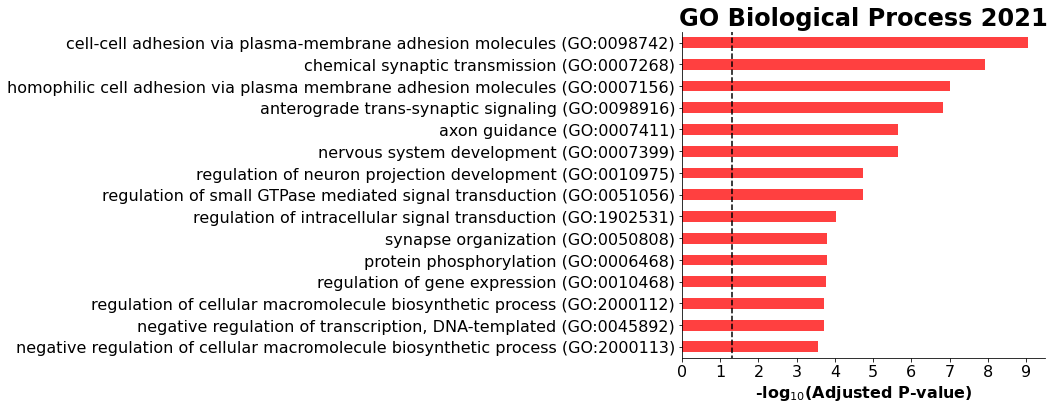

In [38]:
l = -np.log10(0.05)
plot(get_df(go_BP, list(unique_genes_big), background), '', 'GO_Biological_Process_2021')

In [177]:
df_genes.head()

,#GeneName,GeneId,TranscriptId,BioType,variants_impact_HIGH,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_codon_gain_variant,...,variants_effect_frameshift_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_variant,variants_effect_splice_acceptor_variant,variants_effect_splice_donor_variant,variants_effect_splice_region_variant,variants_effect_stop_gained,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant
0,A2M,A2M,XM_030268194.3,protein_coding,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AADAT,AADAT,XM_041715834.1,protein_coding,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,AAR2,AAR2,XM_030288651.3,protein_coding,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,AASDH,AASDH,XM_012573522.4,protein_coding,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AASDH,AASDH,XM_030271137.3,protein_coding,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Распределение по транскриптам:


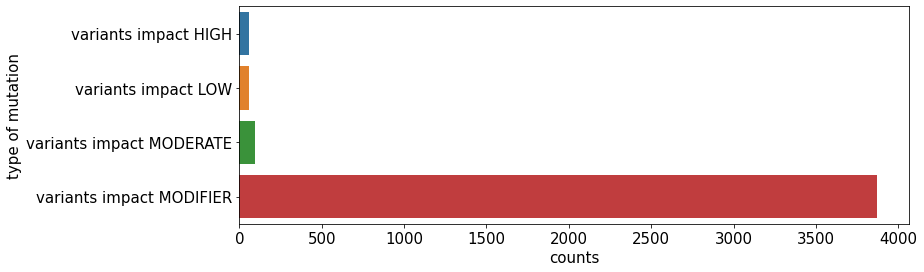

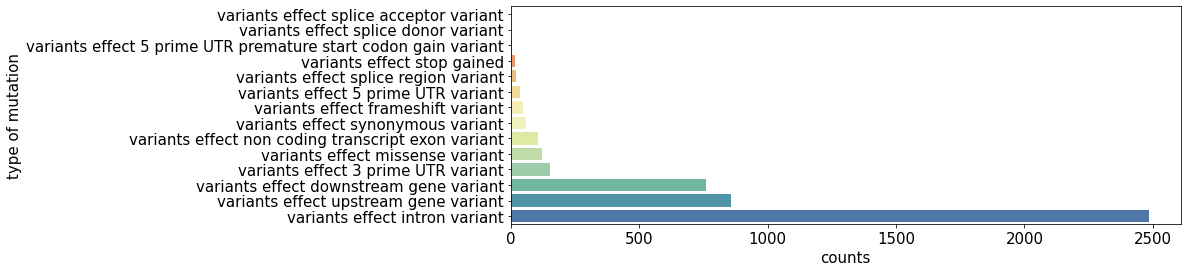

variants_impact_HIGH                                                57
variants_impact_LOW                                                 60
variants_impact_MODERATE                                            97
variants_impact_MODIFIER                                          3871
variants_effect_3_prime_UTR_variant                                151
variants_effect_5_prime_UTR_premature_start_codon_gain_variant       4
variants_effect_5_prime_UTR_variant                                 37
variants_effect_downstream_gene_variant                            758
variants_effect_frameshift_variant                                  45
variants_effect_intron_variant                                    2484
variants_effect_missense_variant                                   120
variants_effect_non_coding_transcript_exon_variant                 106
variants_effect_splice_acceptor_variant                              1
variants_effect_splice_donor_variant                                 1
varian

In [178]:
print('Распределение по транскриптам:')

df_counts_types = pd.DataFrame((df_genes.groupby("GeneId").sum()!=0).sum(), columns = ['counts'])
df_counts_types['type_mut'] = df_counts_types.index
df_counts_types['type_mut'] = df_counts_types['type_mut'].apply(lambda x: ' '.join(x.split('_')))

plt.figure(figsize = (12,4))
sns.barplot(data = df_counts_types[:4].sort_values(by = 'counts', ascending = True), x = 'counts', y = 'type_mut')
plt.ylabel('type of mutation')
plt.savefig(f'{path_to_data}final_data/pics/snpEff_effect_force.png',  bbox_inches='tight', dpi = 400)
plt.show()

a = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True)
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (12,4))

df_counts_sort = df_counts_types[4:].sort_values(by = 'counts', ascending = True) 
df_counts_sort['counts2'] = df_counts_sort['counts'].apply(lambda x: np.log(x))
sns.barplot(data = df_counts_sort, 
            x = 'counts', 
            y = 'type_mut',
           palette = 'Spectral')
plt.ylabel('type of mutation')
plt.savefig(f'{path_to_data}final_data/pics/snpEff_effect_pos.png',  bbox_inches='tight', dpi = 400)
plt.show()
df_counts_types['counts']

In [179]:
df_genes[df_genes['variants_impact_HIGH']>=1].sum()

#GeneName                                                         ACTL10ADCY9ADCY9ANK2ANK2ANK2ANK2ANK2BCO2CACNA1...
GeneId                                                            ACTL10ADCY9ADCY9ANK2ANK2ANK2ANK2ANK2BCO2CACNA1...
TranscriptId                                                      XM_030288865.3XM_002194859.6XM_030285269.3XM_0...
BioType                                                           protein_codingprotein_codingprotein_codingprot...
variants_impact_HIGH                                                                                            125
variants_impact_LOW                                                                                               5
variants_impact_MODERATE                                                                                          9
variants_impact_MODIFIER                                                                                        148
variants_effect_3_prime_UTR_variant                                     

In [180]:
df_genes[(df_genes['variants_impact_HIGH']>=1)
        &(df_genes['variants_effect_stop_gained']>=1)]['#GeneName'].unique()

array(['ANK2', 'CCDC71', 'COL18A1', 'COQ8A', 'DLC1', 'ITGB4', 'KRTCAP3',
       'LOC105758679', 'NDC1', 'NOD1', 'NSD3', 'SETD5', 'TNC', 'ZNF507'],
      dtype=object)

In [181]:
df_genes.head()

,#GeneName,GeneId,TranscriptId,BioType,variants_impact_HIGH,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_codon_gain_variant,...,variants_effect_frameshift_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_variant,variants_effect_splice_acceptor_variant,variants_effect_splice_donor_variant,variants_effect_splice_region_variant,variants_effect_stop_gained,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant
0,A2M,A2M,XM_030268194.3,protein_coding,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AADAT,AADAT,XM_041715834.1,protein_coding,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,AAR2,AAR2,XM_030288651.3,protein_coding,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,AASDH,AASDH,XM_012573522.4,protein_coding,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AASDH,AASDH,XM_030271137.3,protein_coding,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [185]:
df_genes_miss = df_genes[df_genes['variants_effect_missense_variant']>=1]
unique_genes = list(df_genes_miss['GeneId'].unique())
len(unique_genes)

120

In [184]:
df_genes_miss[['#GeneName', 'GeneId', 'TranscriptId', 'BioType',
       'variants_impact_HIGH', 'variants_impact_LOW',
       'variants_impact_MODERATE', 'variants_impact_MODIFIER',
       'variants_effect_missense_variant',
      'variants_effect_stop_gained']]

,#GeneName,GeneId,TranscriptId,BioType,variants_impact_HIGH,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_missense_variant,variants_effect_stop_gained
145,ACTL10,ACTL10,XM_030288865.3,protein_coding,1,0,0,0,1,0
191,ADCY9,ADCY9,XM_002194859.6,protein_coding,1,0,0,2,1,0
192,ADCY9,ADCY9,XM_030285269.3,protein_coding,1,0,0,2,1,0
333,AGBL1,AGBL1,XM_030281428.3,protein_coding,0,1,1,1,1,0
334,AGBL1,AGBL1,XM_030281429.3,protein_coding,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...
12625,ZNF507,ZNF507,XM_030282173.3,protein_coding,1,0,1,0,1,1
12626,ZNF507,ZNF507,XM_030282174.3,protein_coding,1,0,1,0,1,1
12627,ZNF507,ZNF507,XM_030282176.3,protein_coding,1,0,1,0,1,1
12628,ZNF507,ZNF507,XM_030282177.3,protein_coding,1,0,1,0,1,1


In [137]:
get_df(go_BP, unique_genes, background).res2d

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Genes
0,CUSTOM140586248516864,'de novo' posttranslational protein folding (G...,1/27,0.172248,0.324739,7.839039,DNAJB13
1,CUSTOM140586248516864,ATP-dependent chromatin remodeling (GO:0043044),1/38,0.233658,0.360422,5.596447,SMARCA5
2,CUSTOM140586248516864,B cell activation (GO:0042113),1/59,0.338602,0.435996,3.617689,CR2
3,CUSTOM140586248516864,B cell differentiation (GO:0030183),1/41,0.249606,0.375658,5.191159,CR2
4,CUSTOM140586248516864,B cell proliferation (GO:0042100),1/12,0.080559,0.301593,17.257926,CR2
...,...,...,...,...,...,...,...
1047,CUSTOM140586248516864,viral mRNA export from host cell nucleus (GO:0...,1/7,0.047807,0.292246,28.769900,THOC1
1048,CUSTOM140586248516864,visual perception (GO:0007601),4/81,0.002492,0.291196,8.077368,EYS;GPR179;COL18A1;TYR
1049,CUSTOM140586248516864,water-soluble vitamin metabolic process (GO:00...,1/50,0.295498,0.404771,4.264214,SHMT1
1050,CUSTOM140586248516864,wound healing (GO:0042060),1/57,0.329255,0.428684,3.743871,JAML


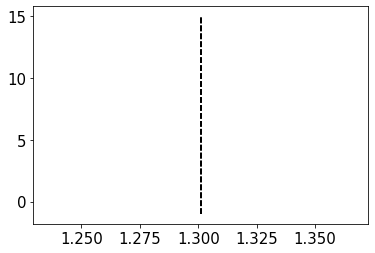

In [131]:
plot(get_df(go_BP, unique_genes, background), 'bg', 'GO_Molecular_Function_2021')
plot(get_df(go_MF, unique_genes, background), 'bg', 'GO_Biological_Process_2021')
plot(get_df(go_CC, unique_genes, background), 'bg', 'GO_Cellular_Component_2021')
plot(get_df(go_reactome, unique_genes, background), 'bg', 'Reactome_2016')

In [158]:
!ls /Users/aleksandradenisova/Desktop/coursework/data/

final_data   stage1       stage3       stage5
initial_data stage2       stage4


In [188]:
df_genes_miss = df_genes[df_genes['variants_effect_missense_variant']>=1]
unique_genes_miss = list(df_genes_miss['GeneId'].unique())
file = open(f'{path_to_data}stage5/genes_miss.txt', 'w')
file.write('\n'.join(unique_genes_miss))
file.close()

In [189]:
df_new[df_new['gene_name'].apply(lambda x: x in unique_genes)].loc[826]['info']

'T|frameshift_variant&missense_variant|HIGH|RELT|RELT|transcript|XM_041713850.1|protein_coding|1/8|c.128_130delG%2CCinsT|p.Arg43fs|1176/3348|128/1095|43/364|'

In [190]:
df_new_miss = df_new[df_new['gene_name'].apply(lambda x: x in unique_genes)]
df_new_miss[['type_of_pos', 'gene_name']].drop_duplicates()['type_of_pos'].value_counts()

cons        85
inno        42
non_inno    36
Name: type_of_pos, dtype: int64

In [193]:
print('\n'.join(unique_genes))

ACTL10
ADCY9
AGBL1
AOC2
ARHGEF33
ASTN1
BAZ2B
BCO2
BOD1L1
BSN
CACNA1E
CADPS
CASKIN2
CCDC88C
CDK9
CEP104
CKAP5
CLEC14A
CLPB
CR2
CREB5
DDB1
DNAH17
DNAJB13
EPG5
EYS
F8
FAM161A
FANCM
FASTKD3
FAT4
FTSJ3
GAPVD1
GARRE1
GGT1
GLI2
GPR179
GRB10
GRM1
GSE1
HTR5A
IFT140
INKA2
INTS8
IQSEC3
ISM2
JAML
KIAA1328
KIAA1549
KIAA2013
KRTCAP3
LINGO1
LNX2
LOC100217969
LOC100218025
LOC100219145
LOC100219675
LOC100223706
LOC100224389
LOC100225136
LOC100225878
LOC100226503
LOC100231134
LOC100232370
LOC101234190
LOC105759186
LOC115497385
LOC121468130
LOC121469259
LRIG2
MAMDC4
MICU3
NCF1
NICN1
NMRAL1
OBSL1
OIT3
OTOG
P2RY4
PDE4D
PFKL
PLA2G12B
PLBD2
PLCXD1
PRAG1
PROB1
RASGEF1C
RELT
RET
RNF213
RSRC2
SALL4
SCARF2
SHMT1
SLC4A4
SLC51A
SMARCA5
SMG8
SPEG
SPG11
SPTB
SVOPL
TARS1
TBC1D4
THOC1
TMEM131
TMEM198
TNRC18
TRIM36
TYR
UBE2K
USH1C
USH2A
WASL
WDR12
WDR6
WNK1
XPNPEP3
ZCCHC17
ZNF507


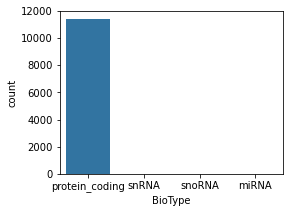

Counts:


protein_coding    11449
miRNA                19
snoRNA               11
snRNA                 4
Name: BioType, dtype: int64

In [45]:
plt.figure(figsize = (4,3))
sns.countplot(data=df_genes, x="BioType")
plt.show()

print("Counts:")
df_genes['BioType'].value_counts()

In [46]:
df_genes[df_genes['BioType']=='snoRNA']

,#GeneName,GeneId,TranscriptId,BioType,variants_impact_HIGH,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_codon_gain_variant,...,variants_effect_frameshift_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_variant,variants_effect_splice_acceptor_variant,variants_effect_splice_donor_variant,variants_effect_splice_region_variant,variants_effect_stop_gained,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant
6356,LOC115495693,LOC115495693,XR_003960995.1,snoRNA,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6361,LOC115495888,LOC115495888,XR_003961213.3,snoRNA,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
6441,LOC115496473,LOC115496473,XR_003961976.1,snoRNA,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,2
6442,LOC115496475,LOC115496475,XR_003961978.1,snoRNA,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,2
6443,LOC115496477,LOC115496477,XR_003961980.1,snoRNA,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,2
6579,LOC115497774,LOC115497774,XR_003963361.3,snoRNA,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6580,LOC115497777,LOC115497777,XR_003963364.3,snoRNA,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6584,LOC115497831,LOC115497831,XR_003963408.3,snoRNA,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6585,LOC115497843,LOC115497843,XR_003963420.3,snoRNA,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6586,LOC115497844,LOC115497844,XR_003963421.3,snoRNA,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [48]:
df_genes[df_genes['variants_effect_missense_variant']>0]

,#GeneName,GeneId,TranscriptId,BioType,variants_impact_HIGH,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_codon_gain_variant,...,variants_effect_frameshift_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_variant,variants_effect_splice_acceptor_variant,variants_effect_splice_donor_variant,variants_effect_splice_region_variant,variants_effect_stop_gained,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant
145,ACTL10,ACTL10,XM_030288865.3,protein_coding,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
191,ADCY9,ADCY9,XM_002194859.6,protein_coding,1,0,0,2,0,0,...,1,2,1,0,0,0,0,0,0,0
192,ADCY9,ADCY9,XM_030285269.3,protein_coding,1,0,0,2,0,0,...,1,2,1,0,0,0,0,0,0,0
333,AGBL1,AGBL1,XM_030281428.3,protein_coding,0,1,1,1,0,0,...,0,1,1,0,0,0,0,0,1,0
334,AGBL1,AGBL1,XM_030281429.3,protein_coding,0,1,1,1,0,0,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12625,ZNF507,ZNF507,XM_030282173.3,protein_coding,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
12626,ZNF507,ZNF507,XM_030282174.3,protein_coding,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
12627,ZNF507,ZNF507,XM_030282176.3,protein_coding,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
12628,ZNF507,ZNF507,XM_030282177.3,protein_coding,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [49]:
[i for i in df_genes['GeneId'].unique() if i.startswith('TRNAP')]

['TRNAP-AGG_1', 'TRNAP-CGG']

In [50]:
df_genes[df_genes['GeneId']=='TRNAP-CGG']

,#GeneName,GeneId,TranscriptId,BioType,variants_impact_HIGH,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_codon_gain_variant,...,variants_effect_frameshift_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_variant,variants_effect_splice_acceptor_variant,variants_effect_splice_donor_variant,variants_effect_splice_region_variant,variants_effect_stop_gained,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant
11900,TRNAP-CGG,TRNAP-CGG,unassigned_transcript_14,protein_coding,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
